In [1]:
import os,sys
import numpy as np
import copy

codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import nsd_utils, default_paths, coco_utils
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
from model_fitting import initialize_fitting
from plotting_and_analysis import plot_utils 

In [2]:
subject = 1;
fn2load = os.path.join(default_paths.sketch_token_feat_path, 'PCA','S%d_PCA.npy'%subject)
pc_result = np.load(fn2load, allow_pickle=True).item()

scores_each_prf = pc_result['scores']
wts_each_prf = pc_result['wts']
ev_each_prf = pc_result['ev']

In [3]:
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)  
n_prfs = models.shape[0]

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [107]:
mm1 = 0
mm2 = 100
up_to_pc = 8

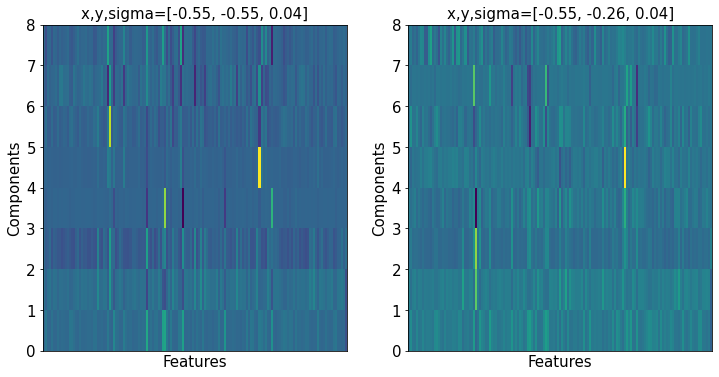

In [108]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(12,6));

mm2plot = [mm1, mm2]
npx = 1
npy = 2

for mi, mm in enumerate(mm2plot):
    wts = wts_each_prf[mm]
    # wts is components x features
    plt.subplot(npx,npy,mi+1)
    
    plt.pcolormesh(wts[0:up_to_pc,:])

    plt.xticks([]) 
    plt.ylabel('Components')
    plt.xlabel('Features')
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    

In [109]:
def test_pc_match(w1, w2, up_to_pc=None):

    n_pcs = w1.shape[0]
    assert(w2.shape[0]==n_pcs)
    if up_to_pc is not None:
        n_pcs = np.min([up_to_pc, n_pcs])
   
    if len(w2.shape)<3:
        w2 = w2[:,:,np.newaxis]
    n_trfs = w2.shape[2]
    
    wdot = np.tensordot(w1, w2, axes=(1,1))

        
    good_match = np.zeros((n_pcs,n_trfs))==1
    for pc in range(n_pcs):
        # check to see if any other pc weight vectors are a better match for it than the one at same position.
        is_max_in_column = pc==np.argmax(wdot[:,pc,:], axis=0)
        is_max_in_row = pc==np.argmax(wdot[pc,:,:], axis=0)
        good_match[pc,:] = is_max_in_column & is_max_in_row

    
    return good_match

In [104]:
 
def find_best_trf(w1, w2, max_iter=100):
    
    up_to_pc = w1.shape[0]
    assert(w2.shape[0]==up_to_pc)
    
    # List all the possible ways to multiply some set of PCs by -1 
    all_combs = []
    for n in range(up_to_pc+1):
        combs_n = list(itertools.combinations(np.arange(up_to_pc),n))
        all_combs+=combs_n

    negate_elements = np.array([np.isin(np.arange(0,up_to_pc), comb).astype(int) for comb in all_combs])
    negate_elements[negate_elements==1] = -1
    negate_elements[negate_elements==0] = 1
    assert(np.unique(negate_elements, axis=1).shape[0]==negate_elements.shape[0])

    # List all the possible ways to swap pairs of PC with one another
    flip_combs = list(itertools.combinations(np.arange(up_to_pc),2))  

    best_trf_m = np.eye(up_to_pc).astype(np.int64)
    best_match_list = test_pc_match(w1, best_trf_m @ w2, up_to_pc=up_to_pc)
    best_n_mismatched = np.sum(~best_match_list)
    best_first_mismatch = np.where(~best_match_list)[0][0]
    
    print('Initialization:')
    print('best trf has %d mismatched'%best_n_mismatched)
    print('best trf has %d matched before first mismatch'%best_first_mismatch)
    print('best trf matrix:')
    print(best_trf_m)
    
    ii=0
    while best_n_mismatched>0 and ii<max_iter:
        ii+=1

        best_m_iter = best_trf_m

        print('iter %d: trying all the pairwise flips'%ii)
        for flip_inds in flip_combs:

            curr_m = copy.deepcopy(best_m_iter)
            curr_m[[flip_inds],:] = curr_m[[flip_inds[1], flip_inds[0]],:]

            poss_transforms = np.tile(curr_m[:,:,np.newaxis], [1,1,negate_elements.shape[0]]) * negate_elements.T[np.newaxis, :,:]
            w2_poss_transforms = np.moveaxis(np.tensordot(w2, poss_transforms, axes=(0,1)), [0,1,2], [1,0,2])

            good_match = test_pc_match(w1, w2_poss_transforms, up_to_pc=up_to_pc)

            n_mismatched_each_trf = np.sum(~good_match, axis=0)
            
#             print([np.where(~good_match[:,cc])[0] for cc in range(good_match.shape[1])])
            first_mismatch = np.array([np.where(~good_match[:,cc])[0][0] if np.any(~good_match[:,cc]) \
                              else up_to_pc for cc in range(good_match.shape[1]) ])
                              
#             print(first_mismatch)
#             if any(n_mismatched_each_trf < best_n_mismatched):
            if any(first_mismatch > best_first_mismatch):

                print('found better transform')

                min_mismatched = np.min(n_mismatched_each_trf)
                if np.sum(n_mismatched_each_trf==min_mismatched)>1:
                    print('there is a tie for best transformation')

                best_trf_ind = np.argmin(n_mismatched_each_trf)
                curr_m = poss_transforms[:,:, best_trf_ind]

    #             print(curr_m)
                best_trf_m = curr_m
                best_n_mismatched = min_mismatched
                best_match_list = good_match[:,best_trf_ind]
                best_first_mismatch = first_mismatch[best_trf_ind]

    print('best trf has %d mismatched'%best_n_mismatched)
    print('best trf has %d matched before first mismatch'%best_first_mismatch)
    print('best trf matrix:')
    print(best_trf_m)
    
    return best_trf_m, best_match_list

In [110]:
import itertools

w1 = copy.deepcopy(wts_each_prf[mm1][0:up_to_pc,:])
w2 = copy.deepcopy(wts_each_prf[mm2][0:up_to_pc,:])  

best_trf_m, best_match_list = find_best_trf(w1, w2)

Initialization:
best trf has 4 mismatched
best trf has 3 matched before first mismatch
best trf matrix:
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]
iter 1: trying all the pairwise flips
iter 2: trying all the pairwise flips
iter 3: trying all the pairwise flips
iter 4: trying all the pairwise flips
iter 5: trying all the pairwise flips
iter 6: trying all the pairwise flips
iter 7: trying all the pairwise flips
iter 8: trying all the pairwise flips
iter 9: trying all the pairwise flips
iter 10: trying all the pairwise flips
iter 11: trying all the pairwise flips
iter 12: trying all the pairwise flips
iter 13: trying all the pairwise flips
iter 14: trying all the pairwise flips
iter 15: trying all the pairwise flips
iter 16: trying all the pairwise flips
iter 17: trying all the pairwise flips
iter 18: trying all the pairwise flips
iter 19: trying all the pairwise flips
iter 20: tr

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

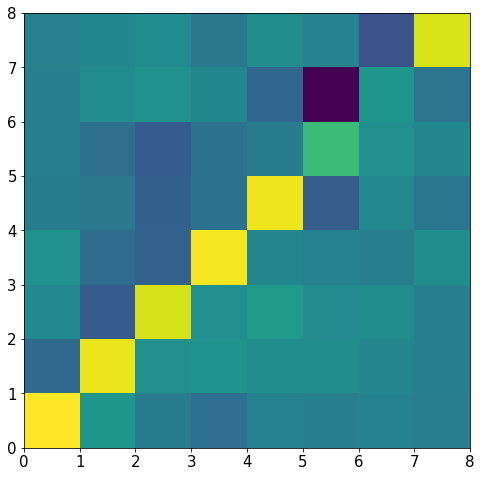

In [106]:
# Visualize the best alignment

w1 = copy.deepcopy(wts_each_prf[mm1][0:8,:])
w2 = copy.deepcopy(wts_each_prf[mm2][0:8,:])   

w2 = best_trf_m @ w2[0:10,:]

wdot = np.tensordot(w1, w2, axes=(1,1))

plt.figure(figsize=(8,8));
plt.pcolormesh(wdot[0:10,0:10])

test_pc_match(w1, w2, up_to_pc=10)

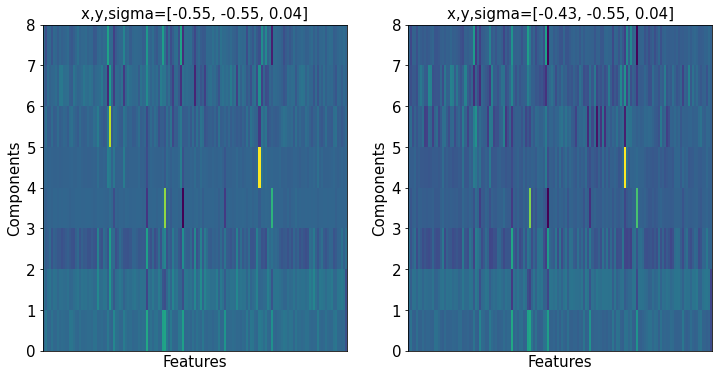

In [100]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(12,6));

mm2plot = [0,2]
npx = 1
npy = 2

for mi, mm in enumerate(mm2plot):
    wts = copy.deepcopy(wts_each_prf[mm][0:up_to_pc,:])
    
    if mi==1:

        wts = best_trf_m @ wts
    
    # wts is components x features
    plt.subplot(npx,npy,mi+1)
    
    plt.pcolormesh(wts[0:up_to_pc,:])

    plt.xticks([]) 
    plt.ylabel('Components')
    plt.xlabel('Features')
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    

In [4]:
scores_each_prf[0].shape

(10000, 100)

In [11]:
models[np.array([420, 450, 508, 540, 700, 776, 830, 852, 870])]

array([[-0.15714286, -0.47142857,  0.05557982],
       [-0.15714286, -0.31428571,  0.05557982],
       [-0.31428571,  0.        ,  0.05557982],
       [-0.15714286,  0.15714286,  0.05557982],
       [ 0.44      ,  0.11      ,  0.07722791],
       [ 0.39285714, -0.07857143,  0.10730783],
       [-0.11      ,  0.11      ,  0.14910375],
       [ 0.18333333, -0.18333333,  0.207179  ],
       [ 0.55      ,  0.55      ,  0.28787428]])

In [12]:
np.where(np.logical_and(np.logical_and(np.abs(models[:,0])<0.5,np.abs(models[:,1])<0.5), np.abs(models[:,2])>0.04))

(array([416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
        446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
        461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
        476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
        491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503,
        506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
        521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
        536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548,
        551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
        566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578,
        581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593,
        596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608,
        637, 638, 639, 640, 641, 642, 643, 644, 645